In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline

In [2]:
def gaussian_function(x, y, pars=None, add_noise=False):
    if not pars:
        x0 = np.random.randn(1)[0]+0.5
        y0 = x0+0.5
        fwhm = np.random.normal(loc=1.5,scale=3, size=100).mean()
    else:
        x0, y0, fwhm = pars
        
    func = 10*np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)
    
    if add_noise:
        func = add_noise_func(func)
    
    return func, x0, y0, fwhm

def add_noise_func(input_data, mean_noise=0):
    
    avg_data = np.mean(input_data)
    noise_ = np.random.normal(mean_noise, np.sqrt(avg_data), 1)[0]
    output_data = input_data + noise_
    
    return output_data
    
def output_model(x_d1, y_d1, model=None, pars=None, cnt_point=True):

    temp_df = pd.DataFrame([(i,j) for i in x_d1 for j in y_d1], columns=['x','y'])

    if cnt_point:
        temp_df.loc[len(temp_df)] = [temp_df['x'].mean(),temp_df['y'].mean()]
        
    temp_df = normal_to_coded_var(temp_df)    
    temp_df['outcome'] = temp_df.apply(lambda x: gaussian_function(x['x'], x['y'], pars)[0], axis=1)
    
    if model:
        temp_df['predict'] = model.predict(temp_df[['x','y']])
        temp_df['mape'] = 100*(temp_df['outcome'] - temp_df['predict'])/temp_df['outcome']
        
    return temp_df

def normal_to_coded_var(temp_df, output_pars = False):
        
    mean_x = temp_df['x'].mean()
    mean_y = temp_df['y'].mean()
    range_x = temp_df['x'].max()-temp_df['x'].min()
    range_y = temp_df['y'].max()-temp_df['y'].min()
    
    temp_df['cX'] = (temp_df['x']-mean_x)/(range_x/2)
    temp_df['cY'] = (temp_df['y']-mean_y)/(range_y/2)
    
    if output_pars:
        return mean_x, mean_y, range_x, range_y
    
    return temp_df

def coded_to_normal(pars, x_coded, y_coded):
    mean_x, mean_y, range_x, range_y = pars
    
    real_x = x_coded*(range_x/2) + mean_x
    real_y = y_coded*(range_y/2) + mean_y
    
    return real_x, real_y
    
def plot_contour_fromdf(test_df, fill_value=0, model=None, levels=10, plot_normal_vars=True):
    x, y = 'cX','cY'
    
    if not model:
        hdf = test_df.groupby(input_vars).mean()
        hdfreset = hdf.reset_index()
        hdfreset.columns = [x, y, 'outcome']
        hdfpivot= hdfreset.pivot(x, y).fillna(0)

        X=hdfpivot.columns.levels[1].values
        Y=hdfpivot.index.values
        Xi,Yi = np.meshgrid(X, Y)
        Z=hdfpivot.values
    else:
        X = np.linspace(test_df[x].min(),test_df[x].max(),levels)
        Y = np.linspace(test_df[y].min(),test_df[y].max(),levels)
        Xi,Yi = np.meshgrid(X, Y)
        Z = model.predict(np.c_[Xi.ravel(),Yi.ravel()]).reshape(len(X),len(Y))
        
    if plot_normal_vars:
        temp_df = pd.DataFrame()
        temp_df[x] = Xi.ravel()
        temp_df[y] = Yi.ravel()
        Z = model.predict(temp_df).reshape(len(X),len(Y))
        mean_x, mean_y, range_x, range_y = normal_to_coded_var(test_df, output_pars = True)
        temp_df['x'] = temp_df[x]*(range_x/2) + mean_x
        temp_df['y'] = temp_df[y]*(range_y/2) + mean_y
        X = np.linspace(test_df['x'].min(),test_df['x'].max(),levels)
        Y = np.linspace(test_df['y'].min(),test_df['y'].max(),levels)
        
        Xi,Yi = np.meshgrid(X, Y)
    else:
        mean_x, mean_y = 0, 0
        
    v, u = np.gradient(Z, 0.1, 0.1)
    plt.contourf(Xi, Yi, Z, alpha=0.7)
    plt.colorbar()
    plt.quiver(Xi,Yi,u,v);

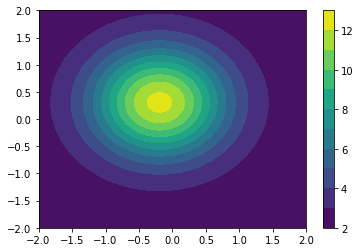

In [3]:
x = np.round(np.linspace(-2,2,101),2)
y = np.round(np.linspace(-2,2,101),2)
X, Y = np.meshgrid(x,y)
Z, x0, y0, fwhm = gaussian_function(X,Y,add_noise=True)
plt.contourf(x,y,Z, levels=10)
plt.colorbar()

In [4]:
def linear_pipe_fit(degree=2, interaction=True, dataframe=pd.DataFrame(), input_vars=['cX','cY']):
    
    lr = LinearRegression()
    pol = PolynomialFeatures(degree=degree, interaction_only=interaction, include_bias=False)
    pipe = Pipeline([('pol',pol), ('lr', lr)])
    pipe.fit(dataframe[input_vars], dataframe['outcome'])
    coefs = pipe['lr'].coef_
    intercept = pipe['lr'].intercept_

    return pipe

def next_step(model=None, increment_y = 1, step_x = 0.125, step_y = 0.125, dataframe=pd.DataFrame()):
    
    mean_x, mean_y, range_x, range_y = normal_to_coded_var(dataframe, output_pars = True)
    
    ratio = model['lr'].coef_[0]/model['lr'].coef_[1]
    
    increment_x = ratio*increment_y*np.sign(model['lr'].coef_[0])
    increment_y = increment_y*np.sign(model['lr'].coef_[1])
    
    print(f'increment x {increment_x:.2f} and increment y {increment_y:.2f} with ratio {ratio:.2f}')
    
    base_x = increment_x*(range_x/2)+dataframe[dataframe.outcome==dataframe['outcome'].max()].x.max()
    base_y = increment_y*(range_y/2)+dataframe[dataframe.outcome==dataframe['outcome'].max()].y.max()
    
    print(f'new x {base_x:.2f} and new y {base_y:.2f}')
                
    next_x = np.round(np.array([base_x-step_x, base_x+step_x]),2)
    next_y = np.round(np.array([base_y-step_y, base_y+step_y]),2)
    
    return next_x, next_y

In [6]:
# first full factorial
x_d1 = np.array([-0.75,-0.5])
y_d1 = np.array([-0.75,-0.5])
test_df = output_model(x_d1, y_d1, pars=(x0, y0, fwhm), cnt_point=False)
test_df

,x,y,cX,cY,outcome
0,-0.75,-0.75,-1.0,-1.0,2.322621
1,-0.75,-0.50,-1.0,1.0,3.743409
2,-0.50,-0.75,1.0,-1.0,2.896728
3,-0.50,-0.50,1.0,1.0,4.668707


In [7]:
normal_to_coded_var(test_df, output_pars = True)

(-0.625, -0.625, 0.25, 0.25)

increment x 0.94 and increment y 2.00 with ratio 0.47
new x -0.38 and new y -0.25
[-0.51 -0.26] [-0.38 -0.12]


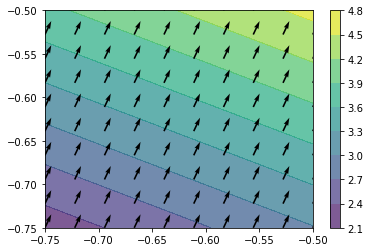

In [8]:
pipe1 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df, input_vars=['cX','cY'])
x_d2, y_d2 = next_step(model=pipe1, increment_y = 2, dataframe=test_df)
plot_contour_fromdf(test_df, fill_value=0, model = pipe1, plot_normal_vars=True)
print(x_d2, y_d2)

increment x 0.66 and increment y 2.00 with ratio 0.33
new x -0.18 and new y 0.14
[-0.3  -0.05] [0.02 0.26]


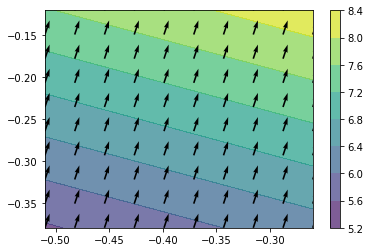

In [9]:
test_df2 = output_model(x_d2, y_d2, model = pipe1, pars=(x0, y0, fwhm), cnt_point=True)
pipe2 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df2, input_vars=['cX','cY'])
plot_contour_fromdf(test_df2, fill_value=0, model = pipe2)
x_d3, y_d3 = next_step(model=pipe2, increment_y = 2, dataframe=test_df2)
print(x_d3, y_d3)

increment x 0.24 and increment y 2.00 with ratio -0.12
new x -0.27 and new y 0.50
[-0.39 -0.14] [0.38 0.62]


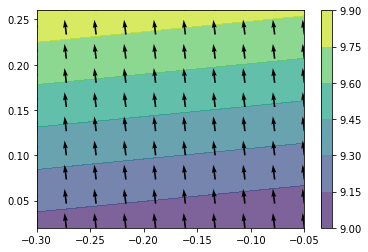

In [10]:
test_df3 = output_model(x_d3, y_d3, pipe2, pars=(x0, y0, fwhm), cnt_point=False)
pipe3 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df3, input_vars=['cX','cY'])
plot_contour_fromdf(test_df3, fill_value=0, model = pipe3)
x_d4, y_d4 = next_step(model=pipe3, increment_y = 2, dataframe=test_df3)
print(x_d4, y_d4)

increment x -0.76 and increment y -2.00 with ratio -0.38
new x -0.23 and new y 0.14
[-0.36 -0.11] [0.02 0.26]


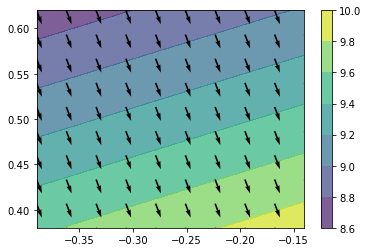

In [11]:
test_df4 = output_model(x_d4, y_d4, pipe3, pars=(x0, y0, fwhm), cnt_point=False)
pipe4 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df4, input_vars=['cX','cY'])
plot_contour_fromdf(test_df4, fill_value=0, model = pipe4)
x_d5, y_d5 = next_step(pipe4, increment_y = 2, dataframe=test_df4)
print(x_d5, y_d5)

increment x 0.51 and increment y 2.00 with ratio 0.26
new x -0.05 and new y 0.50
[-0.17  0.08] [0.38 0.62]


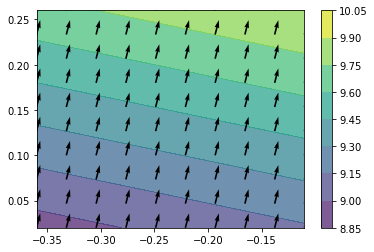

In [12]:
test_df5 = output_model(x_d5, y_d5, pipe4, pars=(x0, y0, fwhm), cnt_point=False)
pipe5 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df5, input_vars=['cX','cY'])
plot_contour_fromdf(test_df5, fill_value=0, model = pipe5)
x_d6, y_d6 = next_step(pipe5, increment_y = 2, dataframe=test_df5)
print(x_d6, y_d6)

increment x -1.60 and increment y -2.00 with ratio 0.80
new x -0.37 and new y 0.14
[-0.5  -0.25] [0.02 0.26]


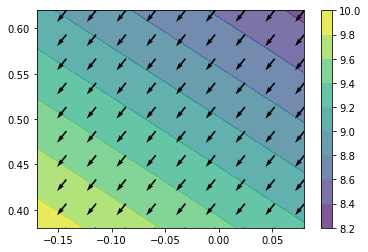

In [13]:
test_df6 = output_model(x_d6, y_d6, pipe5, pars=(x0, y0, fwhm), cnt_point=False)
pipe6 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df6, input_vars=['cX','cY'])
plot_contour_fromdf(test_df6, fill_value=0, model = pipe6)
x_d7, y_d7 = next_step(pipe6, increment_y = 2, dataframe=test_df6)
print(x_d7, y_d7)

In [14]:
steps_df = pd.DataFrame()
x_t = np.array([-0.75,-0.5])
y_t = np.array([-0.75,-0.5])

for i in range(10):
    test_df = output_model(x_t, y_t, pars=(x0, y0, fwhm), cnt_point=False)
    test_df['iteration'] = i
    pipe1 = linear_pipe_fit(degree=1, interaction=True, dataframe=test_df, input_vars=['cX','cY'])
    x_t, y_t = next_step(pipe1, increment_y = 1, dataframe=test_df)
    #plot_contour_fromdf(test_df, fill_value=0, model = pipe1, plot_normal_vars=True)
    steps_df = steps_df.append(test_df)
    max_outcome = test_df['outcome'].max()
    
    if max_outcome < steps_df['outcome'].max():
        print(f'maximum found at iteration {i}')
        break
    print(x_t, y_t)

increment x 0.47 and increment y 1.00 with ratio 0.47
new x -0.44 and new y -0.38
[-0.57 -0.32] [-0.5  -0.25]
increment x 0.37 and increment y 1.00 with ratio 0.37
new x -0.27 and new y -0.12
[-0.4  -0.15] [-0.25  0.  ]
increment x 0.19 and increment y 1.00 with ratio 0.19
new x -0.13 and new y 0.12
[-0.25 -0.  ] [0.   0.25]
increment x 0.38 and increment y 1.00 with ratio -0.38
new x -0.20 and new y 0.38
[-0.33 -0.08] [0.25 0.5 ]
increment x -0.15 and increment y -1.00 with ratio -0.15
new x -0.10 and new y 0.12
maximum found at iteration 4


<AxesSubplot:xlabel='x', ylabel='y'>

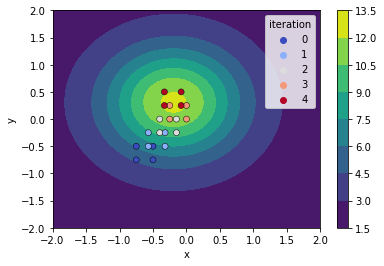

In [15]:
plt.contourf(x,y,Z)
plt.colorbar()
sns.scatterplot(x='x',y='y',data=steps_df, hue='iteration', palette='coolwarm', legend='full', edgecolor='k')

In [16]:
steps_df.head()

,x,y,cX,cY,outcome,iteration
0,-0.75,-0.75,-1.0,-1.0,2.322621,0
1,-0.75,-0.50,-1.0,1.0,3.743409,0
2,-0.50,-0.75,1.0,-1.0,2.896728,0
3,-0.50,-0.50,1.0,1.0,4.668707,0
0,-0.57,-0.50,-1.0,-1.0,4.445790,1


In [17]:
pol = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
lr = LinearRegression()
pipe_all = Pipeline([('pol',pol), ('lr', lr)])
pipe_all.fit(steps_df[['x','y']], steps_df['outcome'])
pipe_all['lr'].coef_

array([-2.12754805,  5.36073023, -6.53973097,  3.49239664, -4.86368571])

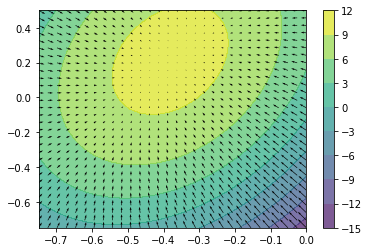

In [18]:
plot_contour_fromdf(steps_df, fill_value=0, model = pipe_all, levels=30)

In [19]:
pipe_all.score(steps_df[['x','y']], steps_df['outcome'])

0.9851623533324838

In [20]:
from sklearn.ensemble import RandomForestRegressor

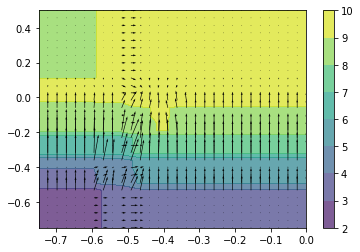

In [21]:
rfr = RandomForestRegressor(max_depth=8)
rfr.fit(steps_df[['x','y']], steps_df['outcome'])
plot_contour_fromdf(steps_df, fill_value=0, model = rfr, levels=30)